In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR


In [2]:
# Load GloVe file
glove_path = './glove/glove.6B.100d.txt'
embeddings_index = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f"Loaded {len(embeddings_index)} word vectors.")

# Load the dataset
dataset = load_dataset("dair-ai/emotion")

train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Label mapping setup
label_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
train_df['label'] = train_df['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)

# Label encoding
label_encoder = LabelEncoder()
label_encoder.fit(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

train_df['label'] = label_encoder.transform(train_df['label'])
val_df['label'] = label_encoder.transform(val_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])

# Dataset Class (Using split() instead of NLTK)
class EmotionDataset(Dataset):
    def __init__(self, data, embeddings_index, max_len=100):
        self.texts = data['text'].tolist()
        self.labels = data['label'].tolist()
        self.embeddings_index = embeddings_index
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Using Python's split() instead of NLTK
        tokens = text.lower().split()

        embeddings = []
        for token in tokens:
            if token in self.embeddings_index:
                embeddings.append(torch.tensor(self.embeddings_index[token]))
            else:
                embeddings.append(torch.zeros(100))

        if len(embeddings) > self.max_len:
            embeddings = embeddings[:self.max_len]
        else:
            while len(embeddings) < self.max_len:
                embeddings.append(torch.zeros(100))

        embeddings = torch.stack(embeddings)
        return embeddings, torch.tensor(label)

# Prepare DataLoader
BATCH_SIZE = 32
train_dataset = EmotionDataset(train_df, embeddings_index)
val_dataset = EmotionDataset(val_df, embeddings_index)
test_dataset = EmotionDataset(test_df, embeddings_index)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)




Loaded 400000 word vectors.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:


# Model initialization function (with weight initialization)
def init_weights(model, init_type='xavier'):
    for layer in model.modules():
        if isinstance(layer, nn.Conv1d) or isinstance(layer, nn.Linear):
            if init_type == 'xavier':
                nn.init.xavier_normal_(layer.weight)
            elif init_type == 'he':
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

# CNN Model definition (same as used in previous code)
class CNNModel(nn.Module):
    def __init__(self, embedding_dim=100, dropout_rate=0.4):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, 6)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(self.relu(self.conv3(x)))
        x = self.pool(x).squeeze(2)
        x = self.fc(x)
        return x

# Model training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        if scheduler is not None:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_loss)
            else:
                scheduler.step()

    return model

# Model evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().tolist())
            y_true.extend(labels.cpu().tolist())

    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Hyperparameter configurations
configurations = [
    {"lr": 0.001, "batch_size": 32, "dropout_rate": 0.4, "epochs": 10, "init": 'xavier', "scheduler": 'ReduceLROnPlateau'},
    {"lr": 0.0005, "batch_size": 32, "dropout_rate": 0.3, "epochs": 5, "init": 'he', "scheduler": 'StepLR'},
    {"lr": 0.001, "batch_size": 64, "dropout_rate": 0.5, "epochs": 10, "init": 'xavier', "scheduler": 'ReduceLROnPlateau'},
    {"lr": 0.0001, "batch_size": 32, "dropout_rate": 0.4, "epochs": 5, "init": 'xavier', "scheduler": None},
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter search loop
for config in configurations:
    print(f"\nTraining with config: {config}")

    # Model initialization
    model = CNNModel(dropout_rate=config['dropout_rate']).to(device)
    init_weights(model, init_type=config['init'])

    # Loss function and optimizer setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    # Scheduler setup
    scheduler = None
    if config['scheduler'] == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    elif config['scheduler'] == 'StepLR':
        scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

    # DataLoader setup
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Train the model
    model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=config['epochs'])

    # Evaluate the model
    evaluate_model(model, test_loader)



Training with config: {'lr': 0.001, 'batch_size': 32, 'dropout_rate': 0.4, 'epochs': 10, 'init': 'xavier', 'scheduler': 'ReduceLROnPlateau'}
Epoch [1/10], Loss: 0.9325
Epoch [2/10], Loss: 0.3924
Epoch [3/10], Loss: 0.2605
Epoch [4/10], Loss: 0.2045
Epoch [5/10], Loss: 0.1681
Epoch [6/10], Loss: 0.1372
Epoch [7/10], Loss: 0.1131
Epoch [8/10], Loss: 0.1045
Epoch [9/10], Loss: 0.0892
Epoch [10/10], Loss: 0.0796
              precision    recall  f1-score   support

       anger       0.91      0.92      0.91       275
        fear       0.93      0.86      0.89       224
         joy       0.88      0.95      0.92       695
        love       0.79      0.72      0.75       159
     sadness       0.96      0.93      0.95       581
    surprise       0.80      0.73      0.76        66

    accuracy                           0.91      2000
   macro avg       0.88      0.85      0.86      2000
weighted avg       0.91      0.91      0.90      2000


Training with config: {'lr': 0.0005, 'batch

Epoch [1/10], Loss: 1.3927, Train Accuracy: 0.4516, Val Accuracy: 0.6230
Epoch [2/10], Loss: 0.8426, Train Accuracy: 0.6836, Val Accuracy: 0.7700
Epoch [3/10], Loss: 0.4320, Train Accuracy: 0.8484, Val Accuracy: 0.8730
Epoch [4/10], Loss: 0.2825, Train Accuracy: 0.8966, Val Accuracy: 0.8915
Epoch [5/10], Loss: 0.2193, Train Accuracy: 0.9193, Val Accuracy: 0.8955
Epoch [6/10], Loss: 0.1812, Train Accuracy: 0.9299, Val Accuracy: 0.9000
Epoch [7/10], Loss: 0.1586, Train Accuracy: 0.9387, Val Accuracy: 0.8980
Epoch [8/10], Loss: 0.1393, Train Accuracy: 0.9425, Val Accuracy: 0.9125
Epoch [9/10], Loss: 0.1216, Train Accuracy: 0.9494, Val Accuracy: 0.9045
Epoch [10/10], Loss: 0.1183, Train Accuracy: 0.9500, Val Accuracy: 0.8995


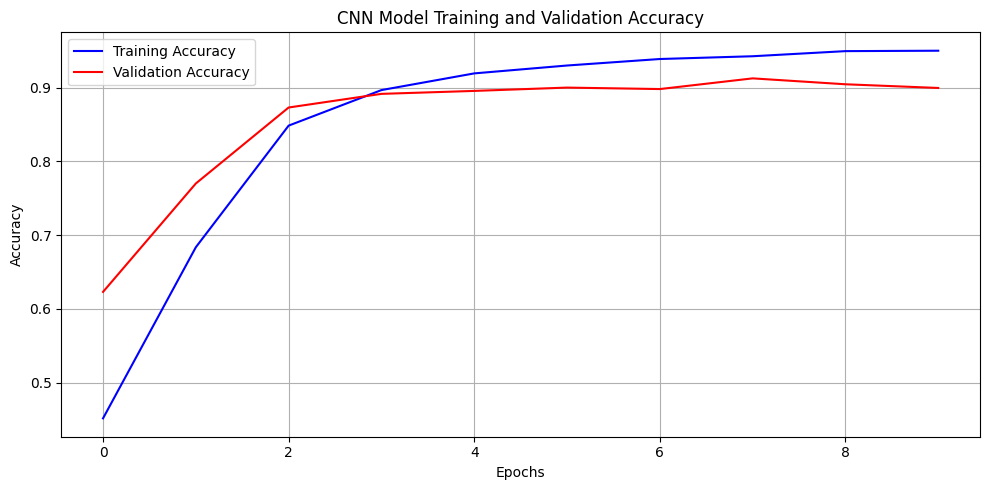

              precision    recall  f1-score   support

       anger       0.89      0.91      0.90       275
        fear       0.92      0.80      0.86       224
         joy       0.89      0.96      0.92       695
        love       0.81      0.79      0.80       159
     sadness       0.97      0.90      0.93       581
    surprise       0.66      0.82      0.73        66

    accuracy                           0.90      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.90      0.90      0.90      2000



In [ ]:


class CNNModelWithAttention(nn.Module):
    def __init__(self, embedding_dim=100):
        super(CNNModelWithAttention, self).__init__()
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, 6)

        # Attention Layer
        self.attention = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=1),
            nn.Tanh(),
            nn.Conv1d(64, 1, kernel_size=1),
            nn.Softmax(dim=2)
        )

        # Grad-CAM related variables
        self.activations = None
        self.gradients = None

        # Register hooks on the module
        self.conv1.register_forward_hook(self._save_activation)
        self.conv1.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def forward(self, x):
        x = x.permute(0, 2, 1)  
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(self.relu(self.conv3(x)))

        # Apply Attention to the output of the last convolution layer
        attention_weights = self.attention(x)  
        attended_features = x * attention_weights  # Apply attention to the features

        x = self.pool(attended_features).squeeze(2)
        x = self.fc(x)
        return x

    # Grad-CAM method
    def generate_grad_cam(self, class_idx=None):
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations not captured. Run a forward and backward pass first.")

        # Compute weights by global average pooling gradients
        weights = torch.mean(self.gradients, dim=(0, 2))

        # Create weighted activation map
        cam = torch.zeros_like(self.activations[0])
        for i, w in enumerate(weights):
            cam += w * self.activations[0, i, :]

        # Apply ReLU to keep only positive influence
        cam = torch.relu(cam)

        # Normalize for visualization
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)

        return cam.detach().cpu().numpy()

    # Method to get attention weights
    def get_attention_weights(self):
        if self.attention_weights is None:
            raise ValueError("Attention weights not captured. Run a forward pass first.")
        return self.attention_weights


# Prepare the model for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModelWithAttention().to(device)

# Hyperparameters
learning_rate = 0.001
batch_size = 32
dropout_rate = 0.4
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Dataloader setup
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize lists to track accuracy
train_accuracies = []
val_accuracies = []

# Train the model
for epoch in range(epochs):
    model.train()
    correct_train = 0
    total_train = 0
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation accuracy calculation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    # Calculate validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    scheduler.step(total_loss/len(train_loader))

# Plot training and validation accuracy after training
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_accuracies, label='Training Accuracy', color='b')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='r')
plt.title('CNN Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().tolist())
        y_true.extend(labels.cpu().tolist())


print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


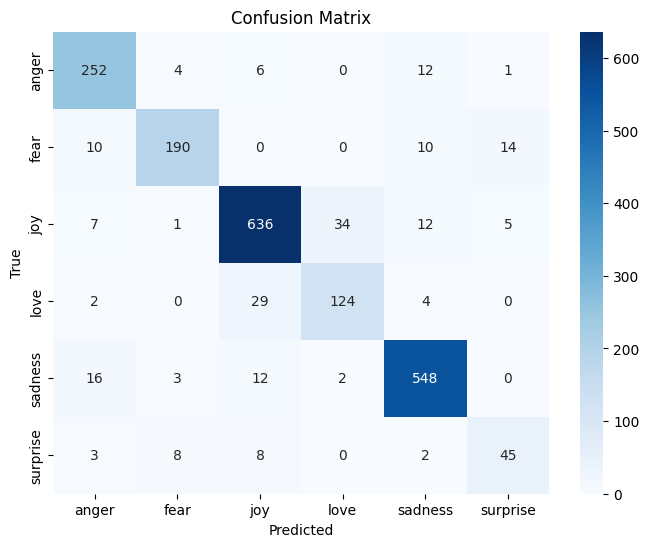

In [ ]:


def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_true, y_pred, label_encoder.classes_)

In [ ]:
import numpy as np

np.set_printoptions(threshold=np.inf)  # This disables truncation
print("Predictions:", y_pred)